# Metastable manifold in a three spin dissipative quantum east model: utilizing symmetries
In this notebook we demonstrate how the general code provided in the metastability module can be used to construct the simplex of an open quantum system which possesses a weak cyclic symmetry: in this case, that of a dissipative quantum east model defined in the model folder, possessing translation invariance.

First we need to import a necessary packages and source code.

In [1]:
import sys
import os
import time
import numpy as np
source_path = os.path.join("source/")
sys.path.insert(0,source_path)
import metastability
import random_linear_algebra
source_path = os.path.join("models/")
sys.path.insert(0,source_path)
import dissipative_quantum_east as dqe
from scipy import linalg
from matplotlib import pyplot
from matplotlib import cm

Next we define the model, at parameters known to exhibit metastability, with a gap between the 4th and 5th eigenmodes.

In [2]:
sites = 3
decay_rate = 1
field = 0.1
temperature = 0.0001
hardness = 0.999
model = dqe.symmetrized_master_operator(sites, decay_rate, field, temperature, hardness)

[[0, 1, 2], [2, 0, 1], [1, 2, 0]]


c:\Users\domin\Dropbox (Personal)\Projects\2017\classical_metastability_open_quantum_ARXIV\Code\source\master_operators.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  conjugated_jumps = np.conjugate(self.jump_operators)
c:\Users\domin\Dropbox (Personal)\Projects\2017\classical_metastability_open_quantum_ARXIV\Code\source\master_operators.py:170: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  conjugated_jump_operators = np.conjugate(self.jump_operators)


Now we need to diagonalize the master operator: this is done by representing the Lindbladian as a matrix, then transforming the resulting eigenvectors into their corresponding matrix representation. The particular class used to define the model in the previous cell takes into account this week symmetry,constructing blocks of the Lindbladian restricted to each eigenspace of the weak symmetry. The model class also contains a spectrum method which calls diagonalization functions, makes the eigenbasis orthonormal, and handles some manipulation of the data into a form that works with the metastability code.

In [3]:
metastable_phases = sites + 1
extra_eigenvalues = 1
eigenvalues, left_eigenmatrices, right_eigenmatrices, symmetry_indices = model.spectrum(
    metastable_phases, extra_eigenvalues)

(1.0044282744492126-2.771967408013775e-11j)


The metastability code assumes the input basis is orthonormal and hermitian. The spectrum method returns an orthonormal basis, but it is not hermitian. We use a function which utilizes information about the symmetry eigenspaces of the eigenmatrices to construct a hermitian basis.

In [4]:

left_eigenmatrices, right_eigenmatrices = dqe.hermitian_basis(
	eigenvalues, left_eigenmatrices, right_eigenmatrices, symmetry_indices, sites)

We now simply input this hermitian basis over the low lying subspace of left eigenmatrices into the symmetry utilizing version of the simplex constructing algorithm described in the paper. As a check, these are then used to construct the probability operators dual to the metastable phases, and subsequently estimate the classicality.

The symmetry aware algorithm requires input of a unitary matrix which applies the action of the symmetry on the state Hilbert space. We extract this (a diagonal matrix since our operators and state are in the basis of symmetry eigenstates) from the symmetry class inside the model on the first line of the next cell.

In [5]:
U = model.symmetry_rep.eigenvalue_matrix()
simplex_vertices = metastability.simplex_vertices(
    left_eigenmatrices[::-1], 
    mode = 'cyclic',
    rotations = 3,
    right_eigenmatrices = right_eigenmatrices[::-1],
    symmetry_transformation = U, 
    power_for_identity = sites)
probability_operators = metastability.probability_operators(left_eigenmatrices[::-1],
                                                            simplex_vertices)
classicality = metastability.classicality(probability_operators)

print("Vertices:")
for i in range(metastable_phases):
	print(np.around(simplex_vertices[i].real, 3))
    
print("\nClassicality:")
print(classicality.real)

Vertices:
[0.    0.    0.005 1.   ]
[ 0.     0.577 -1.149  1.   ]
[ 0.499 -0.288 -1.149  1.   ]
[-0.499 -0.288 -1.149  1.   ]

Classicality:
9.819249144338071e-07


To test this simplex visually, we can project a set of randomly generated initial states onto the coefficients of the hermitian basis of long time modes, and plot them along with the simplex. The stationary state is indicated by the red dot.

In [6]:
states = random_linear_algebra.random_complex_vector(8, 10000)
projected_states = np.einsum('ijk,lk,lj->li', left_eigenmatrices,
                             states, np.conjugate(states))

C:\Users\domin\miniconda3\envs\scipy\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\domin\miniconda3\envs\scipy\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


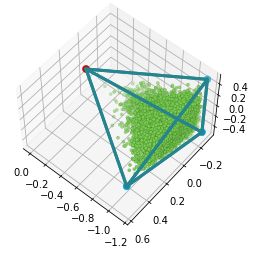

In [8]:
Virid = cm.viridis
ax = pyplot.axes(projection = '3d')
ax.scatter(projected_states.T[1].real, 
           projected_states.T[2].real, 
           projected_states.T[3].real, 
           s = 10, color = Virid(0.8), lw = 0.1, edgecolors = 'k')
for i in range(4):
	for j in range(4):
			pyplot.plot([simplex_vertices.T[2][i], simplex_vertices.T[2][j]], 
                        [simplex_vertices.T[1][i], simplex_vertices.T[1][j]], 
                        [simplex_vertices.T[0][i], simplex_vertices.T[0][j]], 
                        color = Virid(0.45), lw = 3, zorder = 50)
ax.scatter(simplex_vertices.T[2], simplex_vertices.T[1], simplex_vertices.T[0], 
           c = [(0.8,0,0,1), (0,0.6,0.8,1), (0,0.6,0.8,0.6), (0,0.6,0.8,1)],   
           lw = 0.5, s = 50, depthshade = False, zorder = 500)
ax.view_init(55, 130)